In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from Elrond.Helpers.array_utility import pandas_collumn_to_2d_numpy_array
from scipy.signal import spectrogram, welch
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
PATH = '/Users/bensorscher/Library/CloudStorage/GoogleDrive-bsorsch@gmail.com/My Drive/Mouse Training'
fname = 'N2_200203_johncontrasttrack9_train1_stitched'


from spectral_analysis import load_maps, spectral_analysis

maps_data = load_maps(fname, PATH)
N = maps_data.num_neurons
ntrials = maps_data.num_trials
L = maps_data.num_spatial_bins
zmaps = maps_data.z_scored_maps
trial_starts = maps_data.trial_starts

results = spectral_analysis(maps_data)
f_modules = results.frequency_modules
phi_modules = results.phase_modules
grid_cell_idxs_modules = results.grid_cell_idxs_modules
L = results.spatial_bins
trial_starts = results.trial_starts
spectrograms = results.spectrograms

In [ ]:
# Plot PSDs
plt.figure(figsize=(3,8))
nongrid_idxs = np.setdiff1d(np.arange(N), np.concatenate(grid_cell_idxs_modules))
fmax = 8/L
count = 0
Ps = []
for j in range(len(grid_cell_idxs_modules)):
    grid_cell_idxs = grid_cell_idxs_modules[j]
    for i in grid_cell_idxs:
        mp = gaussian_filter1d(zmaps[i,5:45].ravel(), 3)
        f, Pxx = welch(mp,nperseg=4000,noverlap=3000)
        # Ps.append(Pxx[f<fmax])
        Ps.append(Pxx[f<fmax]/(Pxx[f<fmax]).sum())
    count += len(grid_cell_idxs)
    plt.axhline(count, c='grey',linestyle='dashed',linewidth=0.4)
for i in nongrid_idxs:
    mp = gaussian_filter1d(zmaps[i,5:45].ravel(), 3)
    f, Pxx = welch(mp,nperseg=4000,noverlap=3000)
    Ps.append(Pxx[f<fmax]/(Pxx[f<fmax]).sum())
Ps = np.stack(Ps)

plt.pcolormesh(100*f[f<fmax]/2,np.arange(len(Ps)),np.stack(Ps),vmax=0.04)
plt.xlabel(r'Frequency (m$^{-1}$)')
plt.xlim([0,2])
plt.ylabel('Neuron')
plt.tight_layout()
plt.title('PSDs')

In [ ]:
# Module spectrograms
plt.figure(figsize=(20,3))
mi = 2
for i, grid_cell_idxs in enumerate(grid_cell_idxs_modules):
    plt.subplot(1,5,i+1)
    Ng = len(grid_cell_idxs)
    S = spectrograms[grid_cell_idxs].mean(0)
    plt.imshow(S,origin='lower',aspect='auto',vmax=0.25,cmap='magma')
    plt.yticks([0, len(S)/2, len(S)], [0, 1, 2])
    
    if i==0:
        plt.ylabel(r'Frequency ($m^{-1}$)')

    for i in range(1,8):
        plt.axhline(100*i/L/2,linewidth=1,c='grey',alpha=0.5)
        
    for ts in trial_starts[1:-1]:
        plt.axvline(ts,linewidth=1,c='grey',alpha=0.5)
    plt.xlabel('Trials')

In [ ]:
# Plot trajectories on the neural sheet
grid_cell_idxs = grid_cell_idxs_modules[0]
phi = phi_modules[0]
Ng = len(grid_cell_idxs)

maps = gaussian_filter1d(zmaps[grid_cell_idxs].reshape(Ng, -1), 2, axis=1)
# maps = zmaps[grid_cell_idxs].reshape(Ng,-1)
angles = np.arctan2(np.cos(phi)@maps, np.sin(phi)@maps)

plt.figure(figsize=(4,7))
plt.subplot(121)
plt.title(r'$\theta_1$')
plt.imshow(angles[0].reshape(-1,L),cmap='hsv')
for ts in trial_starts[1:-1]:
    plt.axhline(ts,color='k',linestyle='dashed',linewidth=1)
plt.xticks([0,L//2,L],[0,L,2*L])
plt.xlabel('Pos. (cm)')
plt.ylabel('Trial')


plt.subplot(122)
plt.imshow(angles[2].reshape(-1,L),cmap='hsv')
plt.title(r'$\theta_2$')
for ts in trial_starts[1:-1]:
    plt.axhline(ts,color='k',linestyle='dashed',linewidth=1)
plt.yticks([])
plt.xticks([0,L//2,L],[0,L,2*L])
plt.xlabel('Pos. (cm)')

plt.tight_layout(w_pad=0.2)

In [3]:
M26_data = pd.read_pickle("/mnt/datastore/Harry/SpatialLocationManifolds2025/M26_binned_firing_rates_vr.pkl")

Text(0.5, 1.0, 'PSDs')

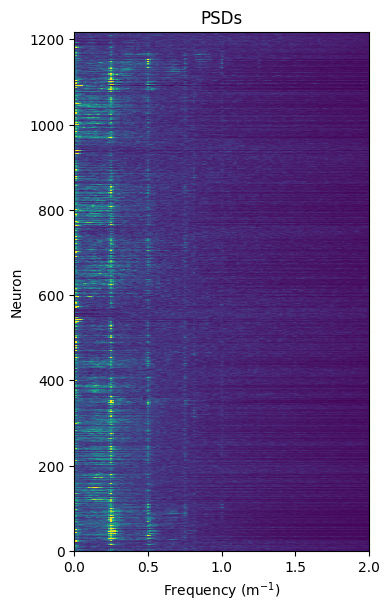

In [8]:
# Plot PSDs
plt.figure(figsize=(4,6))
fmax = 200/1
Ps = []
for j in range(len(M26_data)):
    map = np.array(M26_data.iloc[j]["fr_binned_in_space_smoothed"])
    map[np.isnan(map)] = 0
    zmap = stats.zscore(map)
    mp = gaussian_filter1d(zmap.ravel(), 3)
    f, Pxx = welch(mp,nperseg=4000,noverlap=3000)
    Ps.append(Pxx[f<fmax]/(Pxx[f<fmax]).sum())
Ps = np.stack(Ps)

# Calculate cosine similarity matrix 
similarity_matrix = cosine_similarity(Ps) # Sort rows based on similarity to the first row (change to any row index you prefer) 
sorted_indices = np.argsort(-similarity_matrix[0]) # Sort the array based on the calculated order sorted_array
#Ps = Ps[sorted_indices]

plt.pcolormesh(100*f[f<fmax]/2,np.arange(len(Ps)),np.stack(Ps),vmax=0.04)
plt.xlabel("Frequency (m$^{-1}$)")
plt.xlim([0,2])
plt.ylabel('Neuron')
plt.tight_layout()
plt.title('PSDs')

In [9]:
def plot_psd(data):
    # Plot PSDs
    plt.figure(figsize=(4,6))
    fmax = 200/1
    Ps = []
    for j in range(len(maps_data)):
        map = np.array(data.iloc[j]["fr_binned_in_space_smoothed"])
        map[np.isnan(map)] = 0
        zmap = stats.zscore(map)
        mp = gaussian_filter1d(zmap.ravel(), 3)
        f, Pxx = welch(mp,nperseg=4000,noverlap=3000)
        Ps.append(Pxx[f<fmax]/(Pxx[f<fmax]).sum())
    Ps = np.stack(Ps)

    # Calculate cosine similarity matrix 
    similarity_matrix = cosine_similarity(Ps) # Sort rows based on similarity to the first row (change to any row index you prefer) 
    sorted_indices = np.argsort(-similarity_matrix[0]) # Sort the array based on the calculated order sorted_array
    #Ps = Ps[sorted_indices]

    plt.pcolormesh(100*f[f<fmax]/2,np.arange(len(Ps)),np.stack(Ps),vmax=0.04)
    plt.xlabel("Frequency (m$^{-1}$)")
    plt.xlim([0,2])
    plt.ylabel('Neuron')
    plt.tight_layout()
    plt.title('PSDs')

In [ ]:
M20_data = pd.read_pickle("/mnt/datastore/Harry/SpatialLocationManifolds2025/M20_binned_firing_rates_vr.pkl")
plot_psd(M20_data)

In [ ]:
M21_data = pd.read_pickle("/mnt/datastore/Harry/SpatialLocationManifolds2025/M21_binned_firing_rates_vr.pkl")
plot_psd(M21_data)

In [ ]:
M22_data = pd.read_pickle("/mnt/datastore/Harry/SpatialLocationManifolds2025/M22_binned_firing_rates_vr.pkl")
plot_psd(M22_data)

In [ ]:
M25_data = pd.read_pickle("/mnt/datastore/Harry/SpatialLocationManifolds2025/M25_binned_firing_rates_vr.pkl")
plot_psd(M25_data)

In [ ]:
M26_data = pd.read_pickle("/mnt/datastore/Harry/SpatialLocationManifolds2025/M26_binned_firing_rates_vr.pkl")
plot_psd(M26_data)

In [ ]:
M27_data = pd.read_pickle("/mnt/datastore/Harry/SpatialLocationManifolds2025/M27_binned_firing_rates_vr.pkl")
plot_psd(M27_data)